In [2]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing


# Perameters


In [3]:
cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [95]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')


## Prepare Data  For Training

In [96]:
print(df.columns[:41]) # the last is UV Index
print('Variable Numbers in cheap sensors: 41')
print('Sample Numbers: ',len(df))

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'c02', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index'],
      dtype='object')
Variable Numbers in cheap sensors: 41
Sample Numbers:  199315


# Model Start from here

## Model for Single Wavelength Prediction

In [97]:
target = '450nm' 
target_name = target # this is for display
features = np.append(df.columns[:41], ['Zenith'])
X = df[features]
y = df[[target]] # MLP and scaler use multi output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


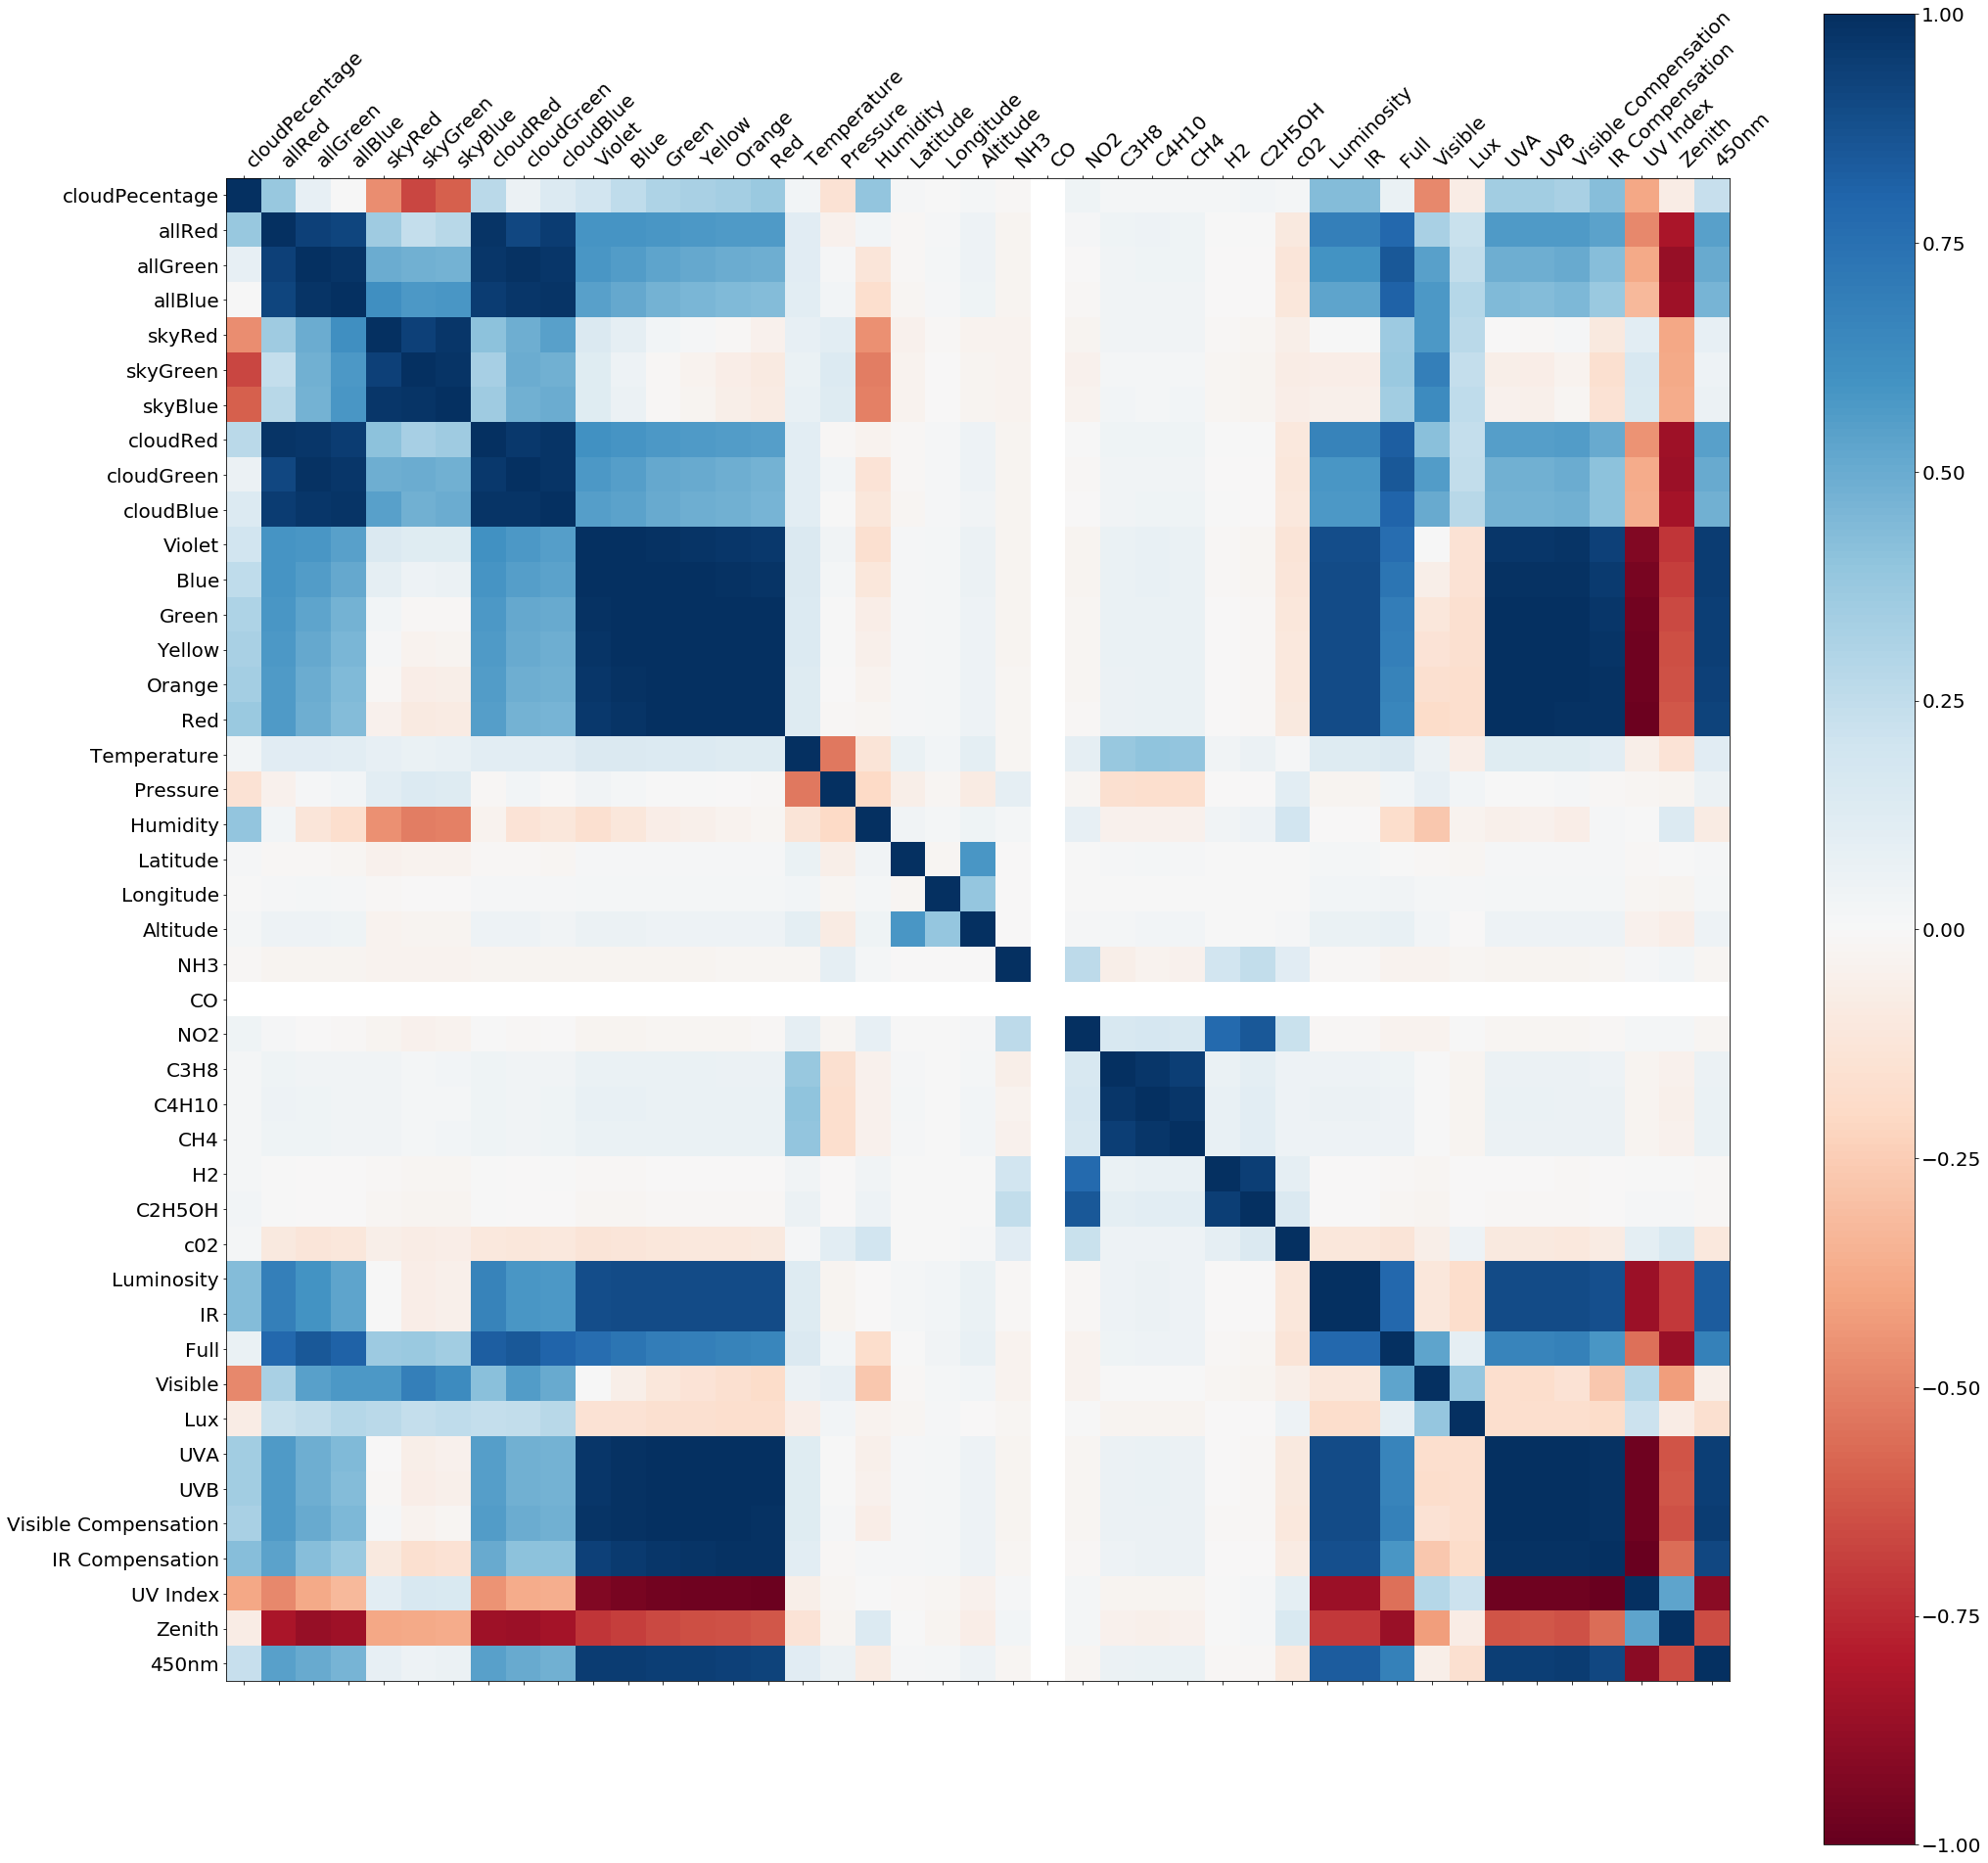

In [98]:
def showCorr(cols):
    size = len(cols)*0.8
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df[cols].corr(), cmap='RdBu')
    cax.set_clim(-1, 1);
    #plt.title('Correlation Matrix\n\n\n')
    fig.colorbar(cax)
    ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
    ax.set_yticklabels(np.append([""],cols))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

showCorr(np.append(features, target))

In [9]:
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

In [1]:
start_time = time.time()

# XGB Model, grid search to find best parameter
regr = XGBRegressor(random_state = RANDOM_STATE,
                     n_jobs = n_jobs
                    )

param_grid = {'max_depth': [6,7,8,9,10],\
              'n_estimators': [100,200]}
CV_regr = GridSearchCV(estimator = regr, param_grid = param_grid, cv =5, verbose = 3)

length_sample = len(X_train)//5
CV_regr.fit(X_train[:length_sample], y_train[:length_sample])
print(CV_regr.best_params_)
print(CV_regr.best_score_)

print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'time' is not defined

In [135]:
n_estimators = 300
max_depth = 7

In [136]:
start_time = time.time()

regr = XGBRegressor(random_state = RANDOM_STATE,
                     n_estimators = n_estimators, # default 100
                     max_depth = max_depth, # default 6
                     n_jobs = n_jobs
                    )
regr.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 70.02354598045349 seconds ---


In [137]:
# save model
structure = '_dep_' + str(max_depth) + '_ne_' + str(n_estimators)
fn_model = '../models/XGB_'+ target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [138]:
# # load model
# fn_model = '../models/XGB_'+ target + '_dep_' + str(max_depth) + '_ne_' + str(n_estimators)+ '.sav'
# regr = pickle.load(open(fn_model, 'rb'))


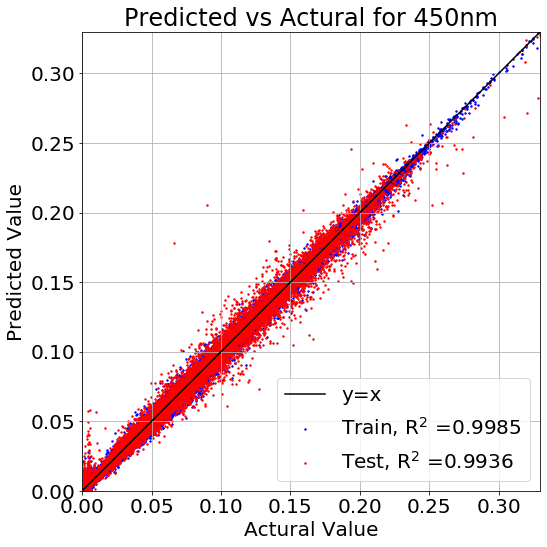

In [139]:
from sklearn.metrics import r2_score

y_train_pred = regr.predict(X_train) # for test score
y_test_pred = regr.predict(X_test) # for test score

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = np.amin(y_train.values)
y_max = np.amax(y_train.values)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min,y_max))
plt.ylim((y_min,y_max))
ax.set_title('Predicted vs Actural for ' + target)
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/XGB_performance_'+target+structure+'.png')


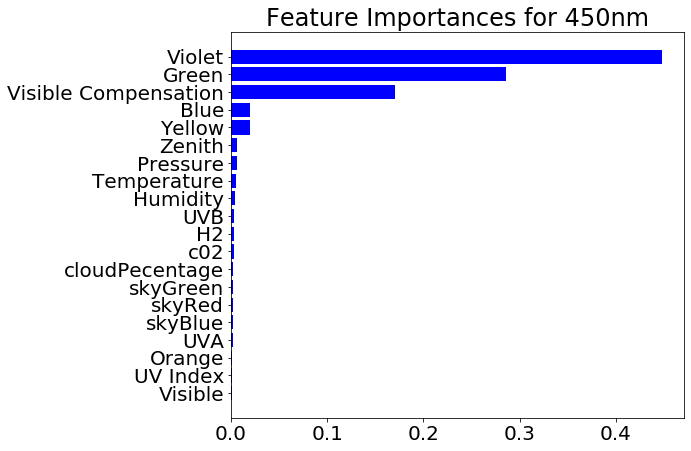

In [140]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        #yerr=std[indices][:num_features],
        ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out + target_name + '/XGB_feature_imp_'+ target_name + structure +'.png')

In [14]:
# Create object that can calculate shap values
num_shap = 50
explainer = shap.KernelExplainer(regr.predict, X_train[:num_shap])
# Calculate shap_values
shap_values = explainer.shap_values(X_train[:num_shap])

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


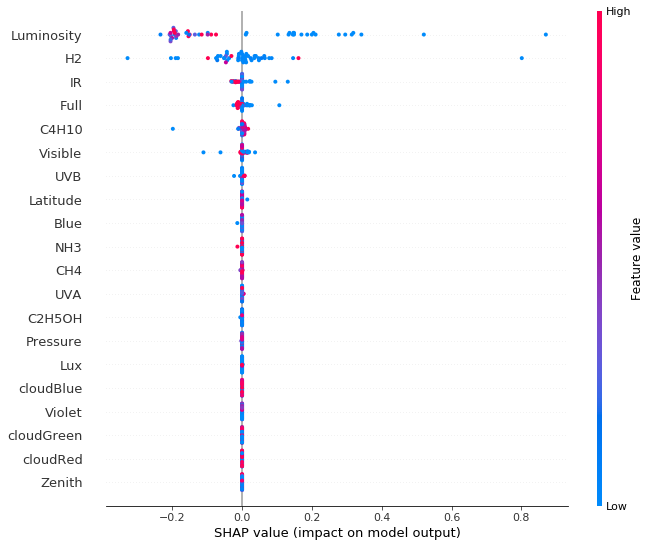

In [16]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(10,8),#'auto'
                  max_display = 20,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target_name + '/MLP_shap_'+ target_name+'.png')

cols = df.columns
size = len(cols)*0.8
fig = plt.figure(figsize=(size, size))
ax = fig.add_subplot(111)
cax = ax.matshow(df[cols].corr(), cmap='RdBu_r')
cax.set_clim(-1, 1);
#plt.title('Correlation Matrix\n\n\n')
fig.colorbar(cax)
ax.set_xticklabels([""]+cols, rotation=45, ha="left")
ax.set_yticklabels([""]+cols)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()